In [20]:
from torchvision import transforms, models
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
MAX_SIZE = 512

def load_image(img_path, max_size=MAX_SIZE, shape=None):

    image = Image.open(img_path).convert('RGB')
    size = min(max_size, max(image.size))

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image


def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + \
        np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, use_leaky_relu=True):
        super(ConvBlock, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(negative_slope=0.2, inplace=True) if use_leaky_relu else nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.activation(x)
        return x

class JoinBlock(nn.Module):
    def forward(self, x1, x2):
        # Resize x1 to the size of x2 for concatenation
        upsampled_x1 = F.interpolate(x1, size=x2.shape[2:], mode='nearest')
        return torch.cat((upsampled_x1, x2), dim=1)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Define the convolutional blocks for each level
        self.conv_block_1 = self._make_layers(3, 8)
        self.conv_block_2 = self._make_layers(3, 8)
        self.conv_block_3 = self._make_layers(3, 8)
        self.conv_block_4 = self._make_layers(3, 8)
        self.conv_block_5 = self._make_layers(3, 8)
        self.conv_block_6 = self._make_layers(3, 8)

        # Define the join blocks
        self.join_block_1 = JoinBlock()
        self.join_block_2 = JoinBlock()
        self.join_block_3 = JoinBlock()
        self.join_block_4 = JoinBlock()
        self.join_block_5 = JoinBlock()

        # Define the post-join convolutional blocks
        self.post_join_conv_block_1 = self._make_layers(16, 16)
        self.post_join_conv_block_2 = self._make_layers(24, 24)
        self.post_join_conv_block_3 = self._make_layers(32, 32)
        self.post_join_conv_block_4 = self._make_layers(40, 40)
        self.post_join_conv_block_5 = self._make_layers(48, 48)

        # Final convolutional layer to create the output texture image
        self.final_conv = ConvBlock(48, 3, 1, use_leaky_relu=False)

    def _make_layers(self, in_channels, out_channels):
        layers = [
            ConvBlock(in_channels, out_channels, 3),
            ConvBlock(out_channels, out_channels, 3),
            ConvBlock(out_channels, out_channels, 1)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        
        # Process the input through each convolutional block at each scale
        conv1 = self.conv_block_1(x)
        conv2 = self.conv_block_2(F.interpolate(x, scale_factor=1/2, mode='bilinear', align_corners=True))
        conv3 = self.conv_block_3(F.interpolate(x, scale_factor=1/4, mode='bilinear', align_corners=True))
        conv4 = self.conv_block_4(F.interpolate(x, scale_factor=1/8, mode='bilinear', align_corners=True))
        conv5 = self.conv_block_5(F.interpolate(x, scale_factor=1/16, mode='bilinear', align_corners=True))
        conv6 = self.conv_block_6(F.interpolate(x, scale_factor=1/32, mode='bilinear', align_corners=True))

        # Perform the joining operations
        join1 = self.join_block_1(conv6, conv5)
        join2 = self.join_block_2(self.post_join_conv_block_1(join1), conv4)
        join3 = self.join_block_3(self.post_join_conv_block_2(join2), conv3)
        join4 = self.join_block_4(self.post_join_conv_block_3(join3), conv2)
        join5 = self.join_block_5(self.post_join_conv_block_4(join4), conv1)

        # Final processing after the last join operation
        result = self.post_join_conv_block_5(join5)

        # Create the final output texture image
        texture = self.final_conv(result)
        return texture

In [22]:
from collections import namedtuple
import torch
import torch.optim as optim
from torchvision import models
from torch.nn import functional as F

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

def get_features(image, model, target_layers=['0', '5', '10', '19', '21', '28']):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in target_layers:
            features[name] = x
    return features

def gram_matrix(tensor):
    _, C, H, W = tensor.size()
    tensor = tensor.view(C, H * W)
    # Compute the Gram matrix
    gram = torch.mm(tensor, tensor.t())

    return gram

# Assume generator is your pre-defined Generator class
generator = Generator().to(device)

# Resize style to match content, makes code easier
style = load_image('images/night.jpg', max_size=512).to(device)
vgg = models.vgg19().features
for param in vgg.parameters():
    param.requires_grad_(False)
vgg.to(device)

style_features = get_features(style, vgg)
style_grams = {name:gram_matrix(style_features[name]) for name in style_features}

In [23]:
style_weights = {'0':1, '5':0.75, '10':0.2, '19':0.2, '21':0.2, '28':0.2}
content_weight = 1  # alpha
style_weight = 1e6  # beta

In [24]:
# for displaying the target image, intermittently
import tqdm

show_every = 400

# iteration hyperparameters
optimizer = optim.Adam(generator.parameters(), lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in tqdm.tqdm(range(1, steps+1)):
    
    content = torch.rand(1, 3, 512, 512).to(device)
    content_features = get_features(content, vgg)
    generated_image = generator(content)
    
    target_features = get_features(generated_image, vgg)
    content_loss = torch.mean((target_features['21'] - content_features['21'])**2)
    
    style_loss = 0
    
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())

 20%|██        | 402/2000 [00:40<02:36, 10.21it/s]

Total loss:  9280.3857421875


 40%|████      | 801/2000 [01:21<02:01,  9.89it/s]

Total loss:  1823.4981689453125


 60%|██████    | 1200/2000 [02:05<01:31,  8.76it/s]

Total loss:  2683.396484375


 80%|████████  | 1600/2000 [02:51<00:49,  8.02it/s]

Total loss:  1840.3177490234375


100%|██████████| 2000/2000 [03:41<00:00,  9.03it/s]

Total loss:  639.8057861328125


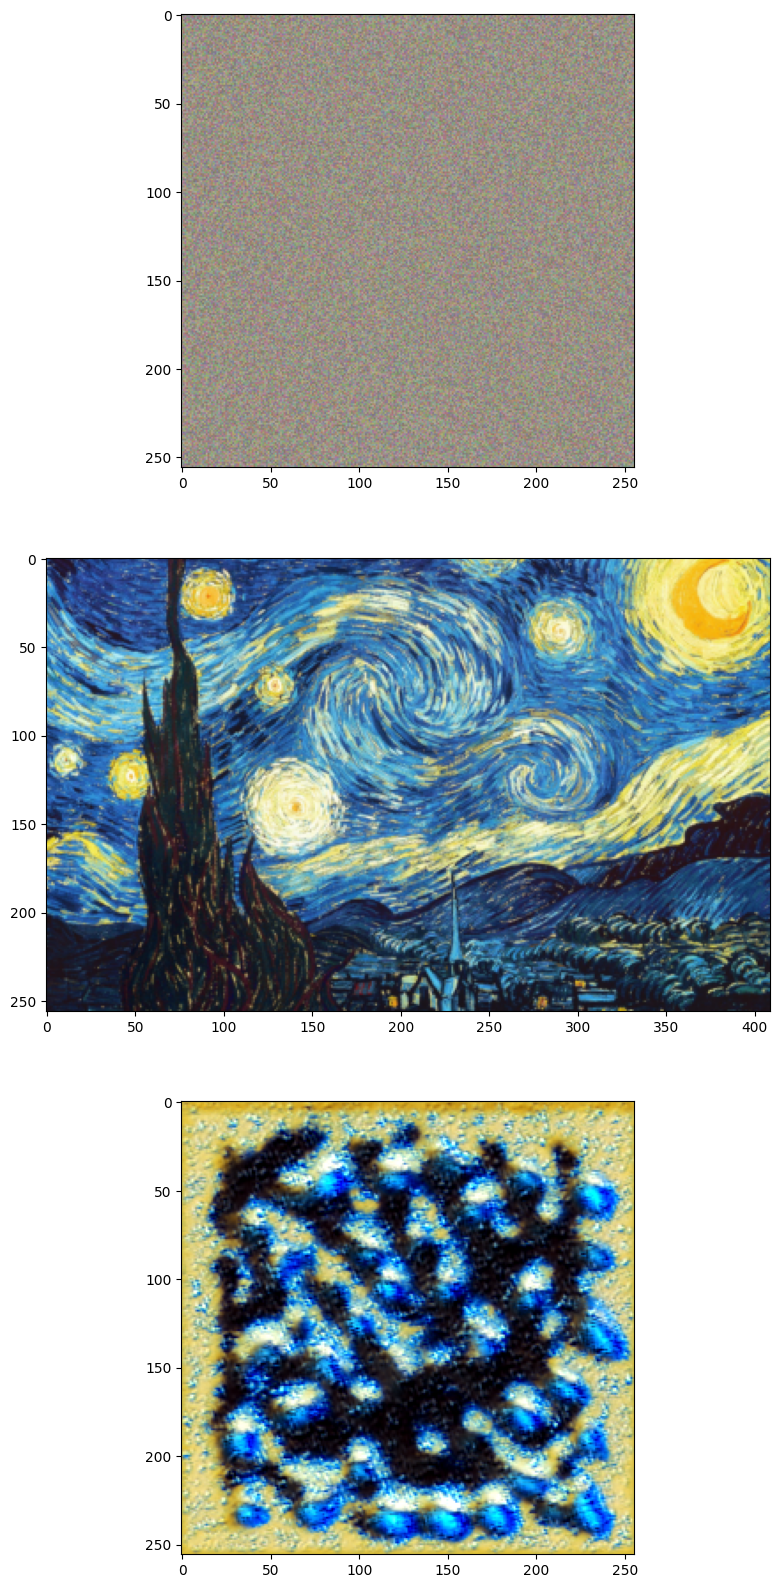

In [25]:
content_image = torch.rand(1, 3, 512, 512).to(device)
with torch.no_grad():
    stylized_image = generator(content_image)
# display content and final, target image
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(40, 20))
ax1.imshow(im_convert(content_image))
ax2.imshow(im_convert(style))
ax3.imshow(im_convert(stylized_image))